## NB - binary classification

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [195]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

#### tolgo record con outliers 

In [196]:
pp_class = pp_class[pp_class["outlier_w_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_w_type"] != True]

### preprocessing variabili

In [197]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

In [198]:
column2drop = ['originalTitle', 'runtimeMinutes']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

#### endYear da gestire

In [199]:
pp_class= pp_class.drop(["endYear"], axis=1)
pp_test_class= pp_test_class.drop(["endYear"], axis=1)

#### Binarizzazione da capire

In [200]:
#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)



# "lowEngagement"

#### Creation of the target variable

In [201]:
pp_class["has_lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test_class["has_lowEngagement"] = (pp_test_class["numVotes"]<100).astype(int)

In [202]:
x = sum(pp_class["has_lowEngagement"] == 1)
x

10287

#### Selezione variabile target

In [203]:
y_train = np.array(pp_class["has_lowEngagement"]) #target originale
y_test = np.array(pp_test_class["has_lowEngagement"])

#### no usato, è gaussian One hot encoding titletype

In [204]:
# title_type_dummies_tr = pd.get_dummies(pp_class['titleType'], prefix='titleType')
# title_type_dummies_ts = pd.get_dummies(pp_test_class['titleType'], prefix='titleType')

# pp_class = pd.concat([pp_class, title_type_dummies_tr], axis=1)
# pp_test_class = pd.concat([pp_test_class, title_type_dummies_ts], axis=1)

## Selezione attributi per classificazione


### con log giuste

In [205]:

num_log_cols = [
    'totalCredits', 
    'numRegions', 
    'criticReviewsTotal',
]

other_num_cols = [
    'rating',
    'fill_runtimeMinutes_Bruno',  
    'startYear',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA', 'countryOfOrigin_EU', 
]

no_num_cols = [
    'canHaveEpisodes', 
    'totalNominations_bin',
    'totalMedia_bin',
]

# --- Log transform and scale for num_cols ---
scaler_num = StandardScaler()
X_train_log_scaled_num = pd.DataFrame(
    scaler_num.fit_transform(np.log1p(pp_class[num_log_cols])),
    columns=num_log_cols,
    index=pp_class.index
)
X_test_log_scaled_num = pd.DataFrame(
    scaler_num.transform(np.log1p(pp_test_class[num_log_cols])),
    columns=num_log_cols,
    index=pp_test_class.index
)

# --- Only scale for other_cols ---
scaler_other = StandardScaler()
X_train_scaled_other = pd.DataFrame(
    scaler_other.fit_transform(pp_class[other_num_cols]),
    columns=other_num_cols,
    index=pp_class.index
)
X_test_scaled_other = pd.DataFrame(
    scaler_other.transform(pp_test_class[other_num_cols]),
    columns=other_num_cols,
    index=pp_test_class.index
)


# --- Mantieni le altre colonne invariate ---
X_train_no_scaled = pp_class[no_num_cols]
X_test_no_scaled = pp_test_class[no_num_cols]

# --- Unisci ---
X_train_temp = pd.concat([X_train_log_scaled_num, X_train_scaled_other, X_train_no_scaled], axis=1)
X_test_temp = pd.concat([X_test_log_scaled_num, X_test_scaled_other, X_test_no_scaled], axis=1)

# --- Ricostruisci l'ordine originale delle colonne ---
original_cols = [col for col in pp_class.columns if col in num_log_cols + other_num_cols + no_num_cols]
X_train_tr = X_train_temp[original_cols]
X_test_tr = X_test_temp[original_cols]


Splitting in train-validation

In [206]:
X_train2_tr, X_val_tr, y_train2, y_val = train_test_split(
     X_train_tr, y_train, test_size=0.2, random_state=32)

## Naive Bayes

In [207]:
clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) #-> non va perchè ci sono valori negativi
clf.fit(X_train2_tr, y_train2)

GaussianNB()

### Prediction on validation set

In [208]:
y_pred = clf.predict(X_val_tr)

In [209]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

2991
2991


In [210]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8107656302240054

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       938
           1       0.85      0.88      0.86      2053

    accuracy                           0.81      2991
   macro avg       0.78      0.77      0.77      2991
weighted avg       0.81      0.81      0.81      2991



In [211]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[5.57776228e-01, 4.42223772e-01],
       [8.10992752e-03, 9.91890072e-01],
       [9.99741191e-01, 2.58809002e-04],
       ...,
       [3.26234101e-02, 9.67376590e-01],
       [6.79516281e-03, 9.93204837e-01],
       [5.21872911e-01, 4.78127089e-01]])

Performance sul Training set:
Accuracy: 0.8023
F1 Score: 0.7988

Performance sul Validation set:
Accuracy: 0.8108
F1 Score: 0.8084


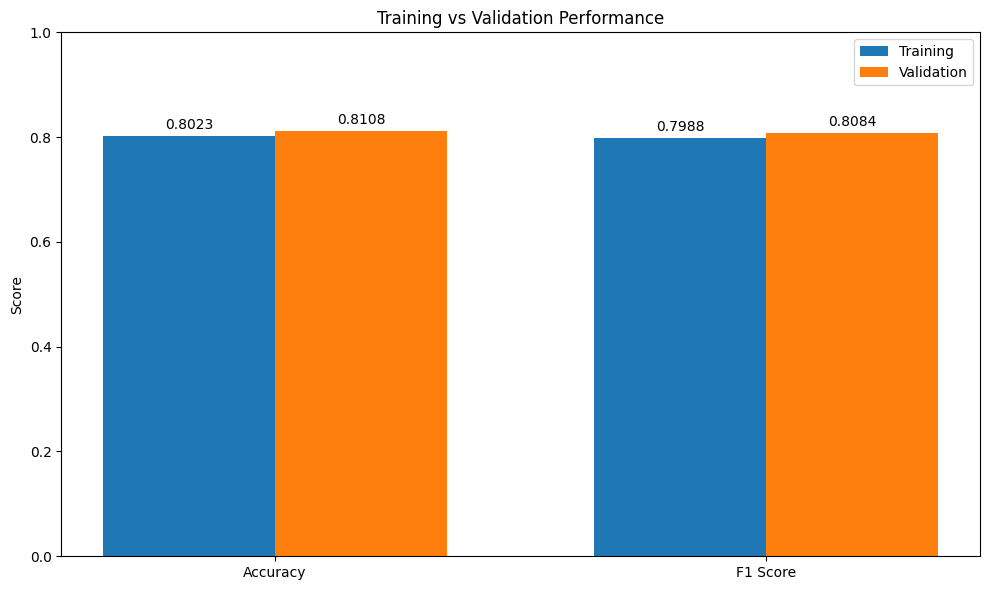

In [212]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [213]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

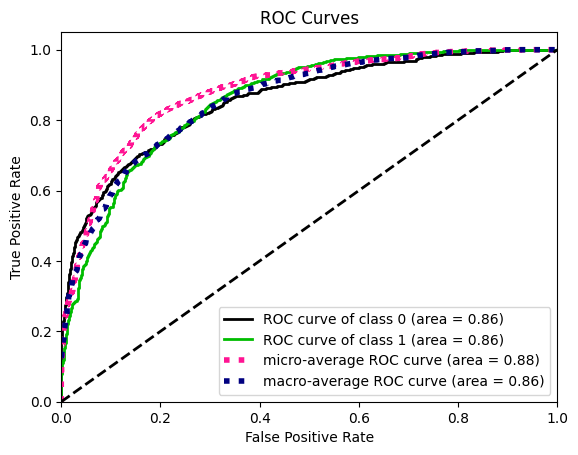

0.8578937474619803


In [214]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

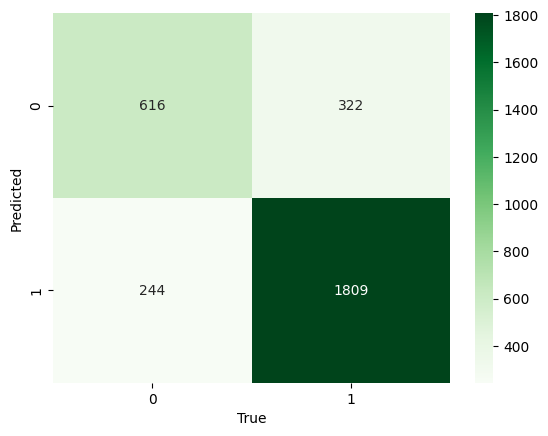

In [215]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## Prediction on the test set

In [216]:
clf = GaussianNB()
# clf = ComplementNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

Performance sul Training set:
Accuracy: 0.8042
F1 Score: 0.8010

Performance sul test set:
Accuracy: 0.8055
F1 Score: 0.8029


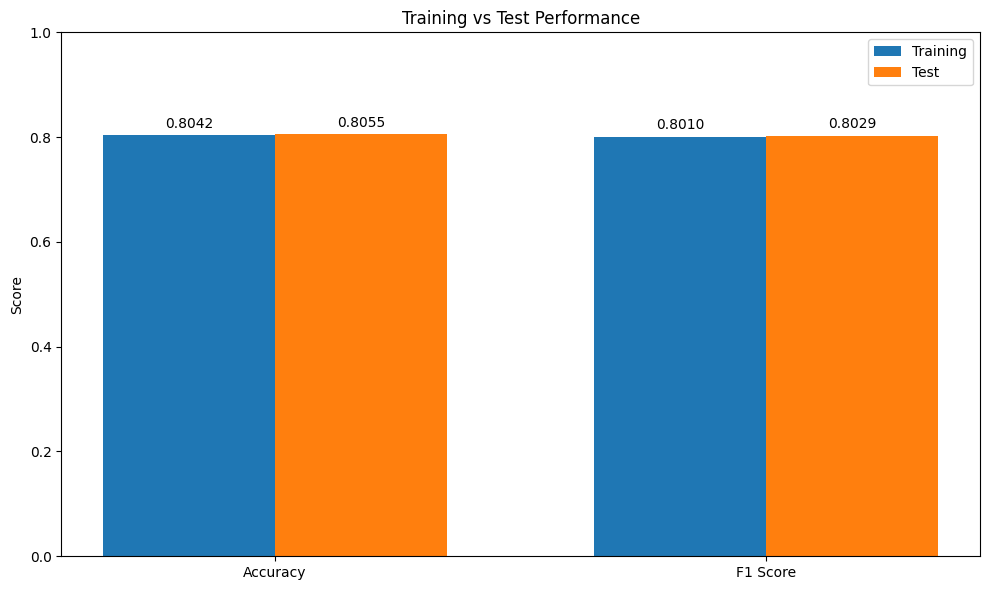

In [217]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### risultati test

In [218]:
class_names = ['high_engagement', 'low_engagement']

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred,target_names=class_names))

Test accuracy: 0.8055053244926663

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.71      0.65      0.68      1561
 low_engagement       0.84      0.88      0.86      3416

       accuracy                           0.81      4977
      macro avg       0.78      0.76      0.77      4977
   weighted avg       0.80      0.81      0.80      4977



In [219]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[2.17830860e-02, 9.78216914e-01],
       [9.99999551e-01, 4.49122452e-07],
       [2.33283694e-02, 9.76671631e-01],
       ...,
       [3.66753526e-02, 9.63324647e-01],
       [6.13401019e-01, 3.86598981e-01],
       [6.16250301e-03, 9.93837497e-01]])

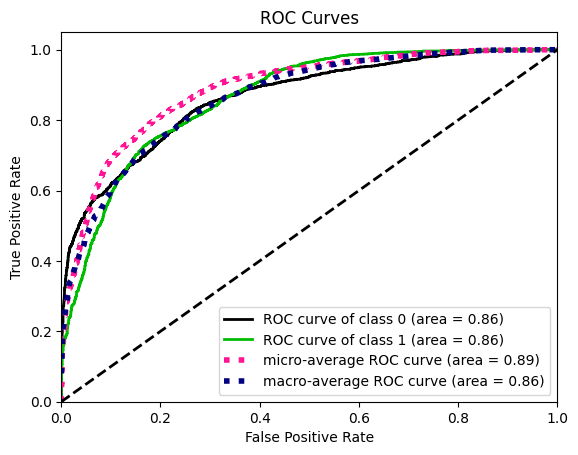

0.8644630461167779


In [220]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

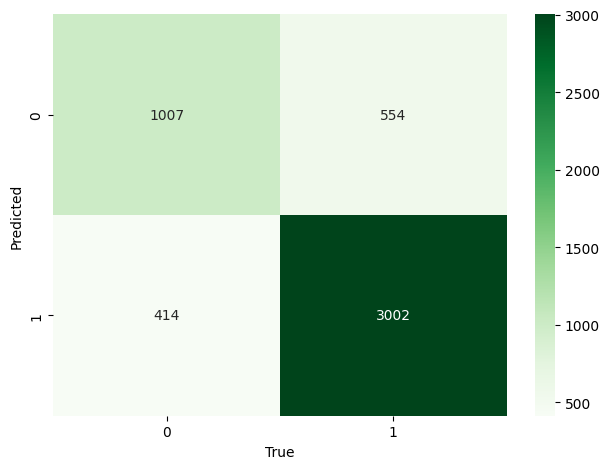

In [221]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

## Dummy classifier 

In [222]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6863572433192686
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1561
           1       0.69      1.00      0.81      3416

    accuracy                           0.69      4977
   macro avg       0.34      0.50      0.41      4977
weighted avg       0.47      0.69      0.56      4977



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
